In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import fwht,ifwht
import pickle
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from scipy.spatial import distance
from matplotlib.collections import LineCollection
import timeit
from scipy.linalg import hadamard
import pandas as pd
from pylab import cm

In [7]:
def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

In [11]:
def fitting(file, nCliffs, nQ, m_max, directory="ZerosInputData/"):
    # load data
    dbfile =open(directory + file,"rb")
    data = pickle.load(dbfile)
    dbfile.close()
    
    # Average over all data of same depth m 
    # to get q(m,|0>) 
    data_ave = np.mean(data, axis=1)
    
    # Perform Walsh Hadamard transform on each q(m,|0>)
    # to get Lambda(m)
    H=np.zeros((len(nCliffs), 2**nQ))
    for i in range(len(nCliffs)):
        for j in range(2**nQ):
            H[i,:] = fwht(data_ave[i,:])
    
    # For each parameter in Lambda(m)
    # Fit to get A_i and alpha_i 
    A = np.zeros(2**nQ)
    alpha = np.zeros(2**nQ)
    for i in range(2**nQ):
        model = LinearRegression()
        model.fit(nCliffs[:m_max].reshape(-1,1),np.log(H[:m_max, i]))
        A[i],alpha[i] = model.intercept_,model.coef_
    
    # Transform A_i into a diagonal matrix
    A = np.diag(np.exp(A))
    alpha = np.exp(alpha)
    
    # Perform Inverse Walsh Hadamard Transform on alpha
    # to get the error rate vector p
    p = projection_simplex_sort(np.array(ifwht(alpha)))
    
    # Shuffle the p vector
    # to get the M matrix for input |0>
    M = np.zeros([2**nQ,2**nQ])
    for i in range(2**nQ):
        for j in range(2**nQ):
            M[i,j] = p[i^j]
            
    
    # Calculate N_0 = W^(-1)AW
    W = hadamard(2**nQ)
    N_0 = np.dot(np.linalg.inv(W),A)
    N_0 = np.dot(N_0,W)
    
    # Calculate the estimated average q'(m) = (W^-1)(A)(W)(M^m)|0> for each depth m
    estimated_ave = np.zeros((len(nCliffs),2**nQ))
    input_vec = np.zeros((2**nQ,1))
    input_vec[0] = 1
    for i in range(len(nCliffs)):
        estimated_ave[i,:] = np.dot(np.linalg.matrix_power(M,nCliffs[i]),input_vec).reshape(2**nQ)
        estimated_ave[i,:] = projection_simplex_sort(np.dot(N_0,estimated_ave[i,:]))
    
    # Compute the JSD distance between the estimated average and the emperical average
    # for each depth m
    JSD = np.zeros(len(nCliffs))
    for i in range(len(nCliffs)):
        JSD[i] = distance.jensenshannon(data_ave[i,:],estimated_ave[i,:])
        
    return JSD

In [12]:
nQ=5
nseeds = 1000
shots=1024
nCliffs=np.arange(1,101)

m_max = [20,50,80]
JSD = np.zeros((3,len(nCliffs)))

for i,m in enumerate(m_max):
    JSD[i] = fitting("Lima", nCliffs, nQ, m)

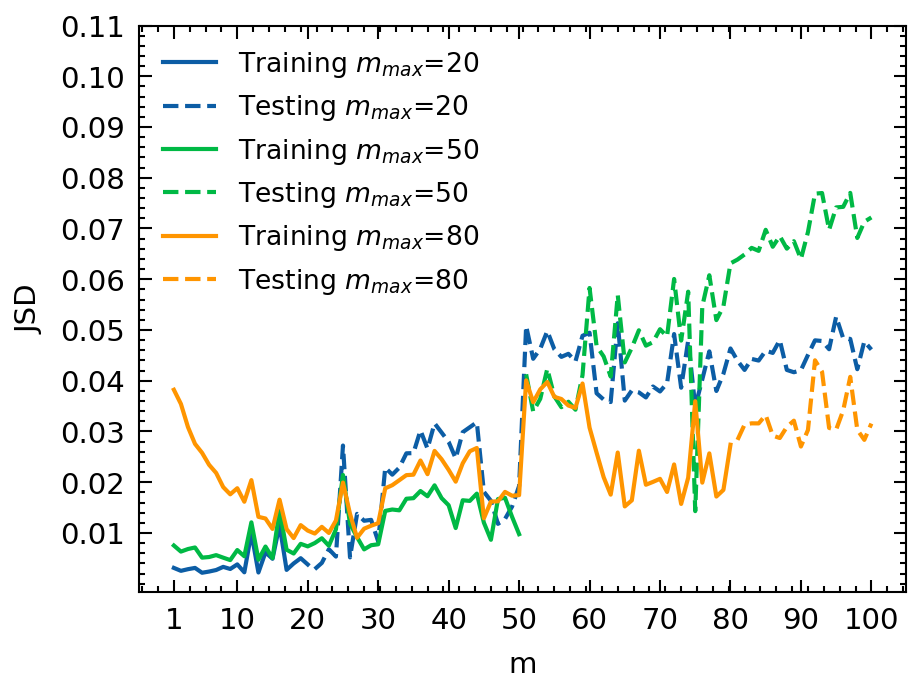

In [20]:
plt.style.use(['science','no-latex','nature'])
fig = plt.figure(dpi=300)
for i,m in enumerate(m_max):
    p0 = plt.plot(nCliffs[:m],JSD[i,:m],label=r"Training $m_{max}$="+str(m))
    plot = plt.plot(nCliffs[m:],JSD[i,m:],'--',color=p0[0].get_color(),label=r"Testing $m_{max}$="+str(m))
plot = plt.legend(fontsize=6.4)
plot = plt.xlabel('m')
plot = plt.ylabel('JSD')
plot = plt.xticks([1,10,20,30,40,50,60,70,80,90,100])
plot = plt.yticks([0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11])
#plt.savefig('Lima')

In [21]:
nQ=5
nseeds = 1000
shots=1024
nCliffs=np.arange(1,101)
m_max = [20,50,80]
computers = ["Manila", "Lima", "Belem"]

results = {}
for computer in computers: 
    results["{}_means".format(computer)]  = []
    results["{}_yerrs".format(computer)]  = []
    
    for m in m_max:
        JSD = fitting(computer, nCliffs, nQ, m)
        results["{}_means".format(computer)].append(np.mean(JSD[m:]))
        results["{}_yerrs".format(computer)].append(np.std(JSD[m:]))

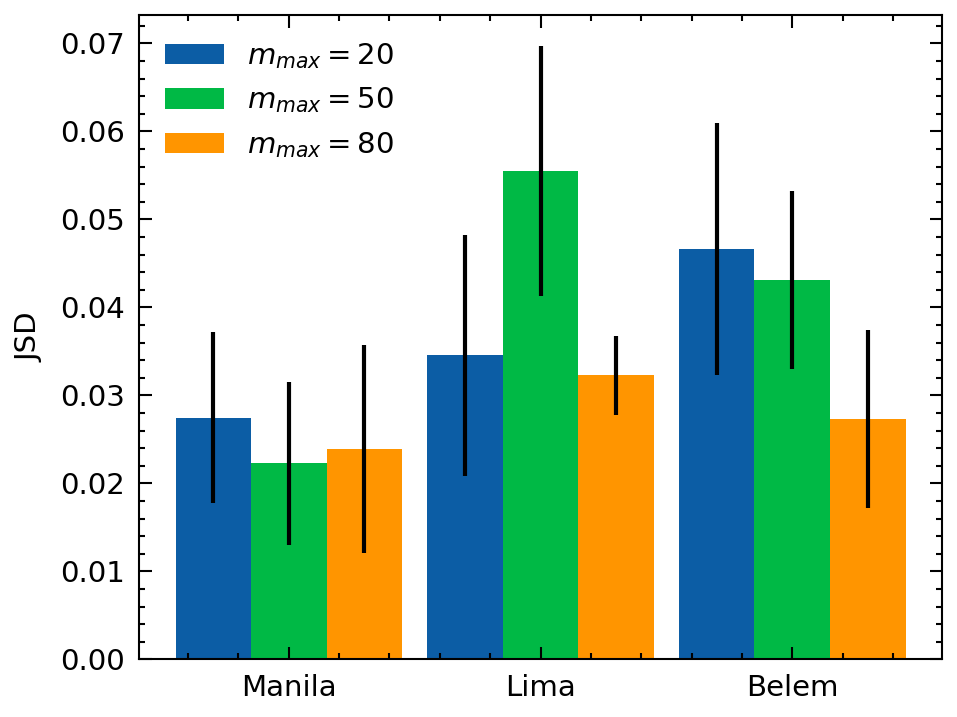

In [22]:
plt.style.use(['science','no-latex','nature'])

means20 = [results["{}_means".format(computer)][0] for computer in computers]
means50 = [results["{}_means".format(computer)][1] for computer in computers]
means80 = [results["{}_means".format(computer)][2] for computer in computers]

yerrs20 = [results["{}_yerrs".format(computer)][0] for computer in computers]
yerrs50 = [results["{}_yerrs".format(computer)][1] for computer in computers]
yerrs80 = [results["{}_yerrs".format(computer)][2] for computer in computers]


x = np.arange(len(computers))
width = 0.3

fig, ax = plt.subplots(dpi=300)
rects1 = ax.bar(x - width, means20, width, label=r'$m_{max}=20$',yerr=yerrs20)
rects2 = ax.bar(x, means50, width, label=r'$m_{max}=50$',yerr=yerrs50)
rects3 = ax.bar(x + width, means80, width, label='$m_{max}=80$',yerr=yerrs80)

ax.set_ylabel('JSD')
ax.set_xticks(x)
ax.set_xticklabels(computers)
ax.legend(loc='upper left')
fig.tight_layout()
#plt.savefig('AthensTestErrorBars',dpi=300)